# DMC Example: Particle in 1D Box

We consider as a test case a particle in a 1D box. This is given by the Hamiltonian

$$
    H = -\frac{1}{2}\partial_x^2,
$$

for $x \in [0, 1]$, with homogeneous Dirichet boundary conditions. The exact ground state solution is

$$
    \psi_0(x) = \sin(\pi x),
$$

with energy

$$
    E_0 = \frac{\langle \psi_0 | H | \psi_0 \rangle}{\langle \psi_0 | \psi_0 \rangle} = \frac{\pi^2}{2} \approx 4.9348.
$$

As a trial function, we use

$$
    \psi_T(x) = x(1 - x),
$$

which has a variational energy

$$
    E_V = \frac{\langle \psi_T | H | \psi_T \rangle}{\langle \psi_T | \psi_T \rangle} = 5 > E_0.
$$

In [1]:
import sys
from pydmc import *
%matplotlib inline

In [13]:
nconf = 40
time_step = 1e-2
reference_energy = 5
blocks = 100
steps_per_block = int(1e-2/time_step * 100)
lag = steps_per_block
neq = 10
a0 = 1
da = 1e-5
hamiltonian = lambda psi, x: -0.5 * psi.laplacian(x)

Next, we create the guiding wave function:

In [14]:
class GuidingWaveFunction(WaveFunction, GeometryParametrized):

    def __init__(self, box_width):
        self._l = box_width

    def __call__(self, x):
        y = x[0]
        return max(0, y*(self._l - y))

    def gradient(self, x):
        return gradient_fd(self, x)
        #return self._l - 2*x
    
    def laplacian(self, x):
        #return laplacian_fd(self, x)
        return -2.0

    def deform(self, da):
        return GuidingWaveFunction(self._l + da)
    
    def geometry_parameters(self):
        return self._l

Now, we generate a set of configurations. In a more advanced algorithm, this should be done by a short VMC run. Here, we just uniformly generate points $x \in [0, 1]$.

In [15]:
guiding_wf = GuidingWaveFunction(a0)

In [16]:
np.random.seed(0)
random.seed(0)

vmc_steps_per_block = 100
vmc_blocks = 100
vmc = VMC(hamiltonian, np.array([0.5]), DiffuseAcceptReject(), guiding_wf)
vmc.run_vmc(1e-2, vmc_steps_per_block, vmc_blocks)

100%|██████████| 100/100 [00:00&lt;00:00, 131.35it/s]


In [17]:
confs = vmc._confs[-nconf:]
walkers = [Walker(conf, 1.0, lag=steps_per_block) for conf in confs]

And finally, initialize the DMC runner and perform diffusion Monte Carlo.

In [7]:
brancher = SRBrancher()
#brancher = SplitJoinBrancher()
#brancher = SimpleBrancher()
#brancher = NoBrancher()

ar = DiffuseAcceptRejectDMC(fixed_node=True)

fas = [
    DMCLogger(da, "dmc.pib1d.hdf5", nconf, cutoff=lambda d: cutoff_tanh(d, 0.05))
]

dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy, force_accumulators=fas)

dmc.run_dmc(time_step, blocks, steps_per_block, neq=neq, progress=True)

100%|██████████| 100/100 [00:40&lt;00:00,  2.50it/s]


The DMC energy estimate is updated and saved during the run. The last value of the estimate is the most accurate energy that was obtained. Additionally, an estimate on the error is computed; this is usually underestimated, so take care.

In [8]:
# Energy: 4.96313 +/- 0.00996
energy = dmc.energy_estimate[-1]
err = dmc.energy_error[-1]
print(f"Energy: {energy:.5f} +/- {err:.5f}")
print(f"Exact:  {np.pi**2/2:.5f}")

Energy: 4.92562 +/- 0.01883
Exact:  4.93480


Let's examine how the energy esimate behaves during the run:

In [7]:
plt.figure()
ns = np.arange(0, len(dmc.energy_estimate))
plt.plot(ns, dmc.energy_estimate, label="DMC energy")
plt.fill_between(ns, 
    dmc.energy_estimate - dmc.energy_error, 
    dmc.energy_estimate + dmc.energy_error, alpha=0.2)

exact = np.pi**2/2                    
plt.plot([0, len(dmc.energy_estimate)], [exact, exact], label="Exact ground state energy")
plt.plot([0, len(dmc.energy_estimate)], [reference_energy, reference_energy], "black", label="Reference energy")
plt.legend()
plt.xlabel("DMC block")
plt.ylabel("Energy (Hartree)")
plt.grid()

AttributeError: module &#39;pydmc.dmc&#39; has no attribute &#39;energy_estimate&#39;

In [7]:
flhf, flhf_warp, flpulay_exact, flpulay_exact_warp, flpulay_vd, flpulay_vd_warp, flpulay_exact_nocutoff, flpulay_exact_nocutoff_warp, weights \
    = DMCForcesInput().compute_forces("dmc.pib1d.hdf5")
force_exact = np.pi**2/a0**3

In [8]:
from plotutil import plot_force_data_trace, plot_error_over_time

## Exact Force

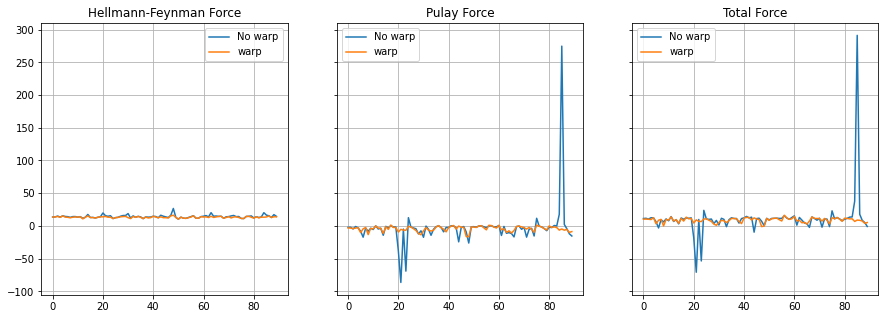

In [9]:
plot_force_data_trace(flhf, flpulay_exact_nocutoff, flhf_warp, flpulay_exact_nocutoff_warp, bin_size=1)

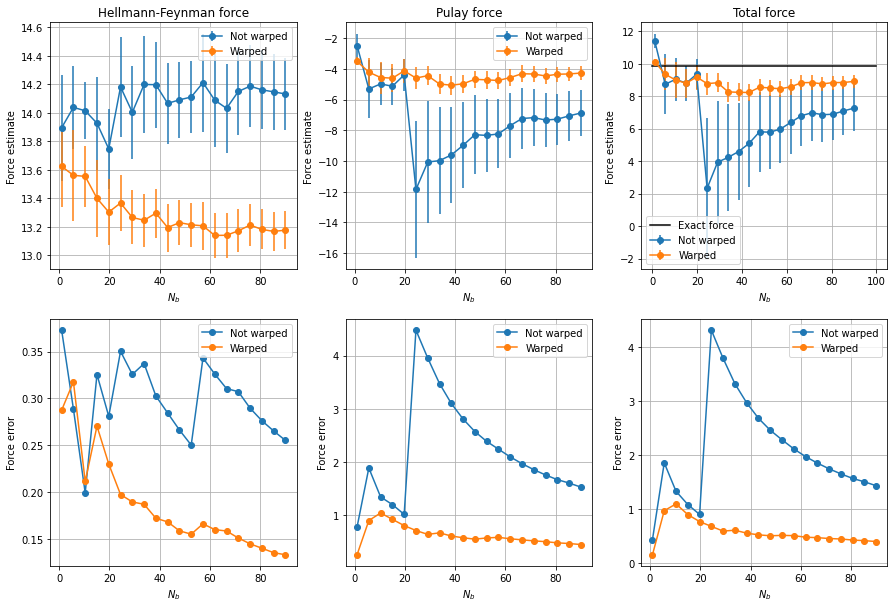

In [10]:
axes = plot_error_over_time(flhf, flpulay_exact_nocutoff, flhf_warp, flpulay_exact_nocutoff_warp, 20, 1, weights=weights)
for (ax, title) in zip(axes.T, ["Hellmann-Feynman force", "Pulay force", "Total force"]):
    ax[0].set_xlabel(r"$N_b$"); ax[1].set_xlabel(r"$N_b$")
    ax[0].set_ylabel("Force estimate"); ax[1].set_ylabel("Force error")
    ax[0].set_title(title)
axes[0, -1].plot([0, blocks], [force_exact]*2, "black", label="Exact force")
axes[0, -1].legend();

## VD Force

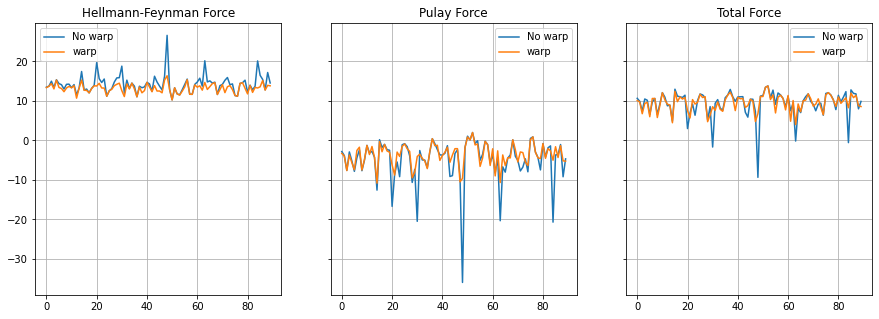

In [11]:
plot_force_data_trace(flhf, flpulay_vd, flhf_warp, flpulay_vd_warp)

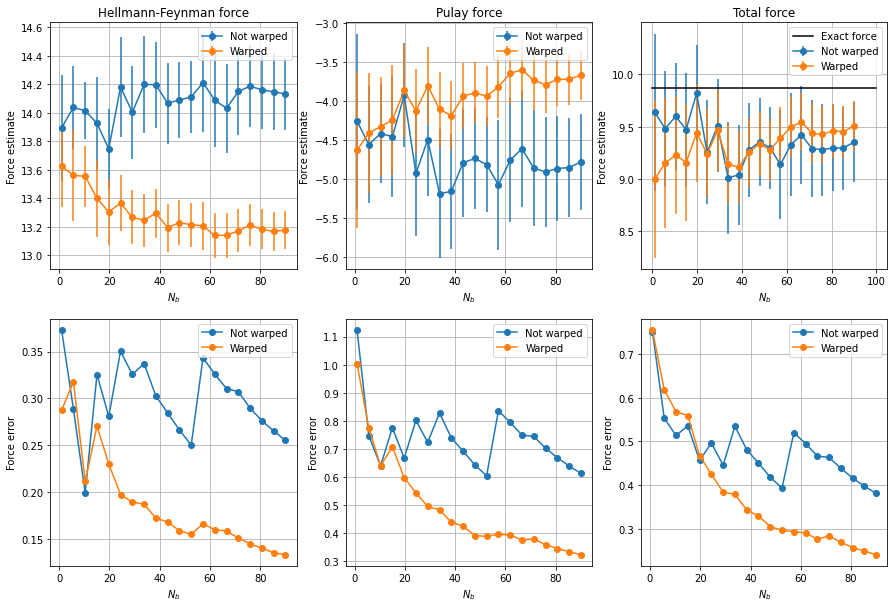

In [12]:
axes = plot_error_over_time(flhf, flpulay_vd, flhf_warp, flpulay_vd_warp, 20, 1, weights=weights)
for (ax, title) in zip(axes.T, ["Hellmann-Feynman force", "Pulay force", "Total force"]):
    ax[0].set_xlabel(r"$N_b$"); ax[1].set_xlabel(r"$N_b$")
    ax[0].set_ylabel("Force estimate"); ax[1].set_ylabel("Force error")
    ax[0].set_title(title)
axes[0, -1].plot([0, blocks], [force_exact]*2, "black", label="Exact force")
axes[0, -1].legend();